In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize

In [ ]:
# スキーム

def distance_matrix(pos):
    n_sample = len(pos)
    
    distance_mtx = np.zeros([n_sample, n_sample])
    for i in range(n_sample):
        for j in range(n_sample):
            dist = np.linalg.norm(pos[i] - pos[j])
            distance_mtx[i,j] = dist
    
    return distance_mtx


def weight_matrix(pos, r_e):
    distance_mtx = distance_matrix(pos)
    weight_mtx = np.where((distance_mtx < r_e)&(distance_mtx > 0), r_e / distance_mtx - 1, 0)
    
    return weight_mtx


def laplacian_u(val, n_0, lambda_0, weight):
    n_sample = len(val)
    dim = 2
    
    laplacian = np.empty([n_sample, dim])
    for i, v in enumerate(val):
        w = np.repeat([weight[i]], dim, axis=0).T
        laplacian[i] = (2*dim)/(lambda_0*n_0) * sum((val - v)* w)
    
    return laplacian


def laplacian_p(press, n_0, lambda_0, weight_mtx):
    n_sample = len(press)
    dim = 2
    
    laplacian = np.empty(n_sample)
    for i in range(n_sample):
        w = weight_mtx[i]
        p = press[i]
        laplacian[i] = (2*dim)/(lambda_0*n_0) * sum((press - p)* w)
    
    return laplacian

def grad_p(press, n_0, pos, distance_mtx, weight_mtx):
    n_sample = len(press)
    dim = 2
    
    grad = np.empty([n_sample, dim])
    for i, p in enumerate(press):
        w = weight_mtx[i]
        d = distance_mtx[i]
        ps = pos[i]
        
        a = np.repeat([(press - p)/(d **2)], 2, axis=0).T
        b = np.repeat([w], 2, axis=0).T
        
        c = a * (pos - ps)* b
        c[np.isnan(c)] = 0 # d=0のときにnanが出るので除外する
        grad[i] = dim/n_0 * np.sum(c, axis=0)
        
    return grad

(-0.1, 1.0)

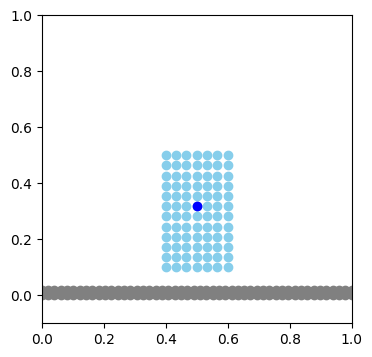

In [241]:
# 初期条件
### 固定壁
x = np.linspace(0, 1, 50)
y = np.linspace(0, 0.02, 2)

xx, yy = np.meshgrid(x, y)
pos_rigid = np.block([[xx.flatten()], [yy.flatten()]]).T
n_sample, dim = pos_rigid.shape
vel_rigid = np.zeros([n_sample, dim])
pttype_rigid = np.ones(n_sample)

### 水柱
x = np.linspace(0.4, 0.6, 7)
y = np.linspace(0.1, 0.5, 12)
xx, yy = np.meshgrid(x, y)
pos_water = np.block([[xx.flatten()], [yy.flatten()]]).T

"""
r = np.linspace(0.01, 0.2, 6)
th = np.linspace(0,2*np.pi, 18)

rr, tth = np.meshgrid(r, th)
xx = rr*np.cos(tth)+0.5
yy = rr*np.sin(tth)+0.5
pos_water = np.block([[xx.flatten()], [yy.flatten()]]).T
"""

n_sample, dim = pos_water.shape
vel_water = np.ones([n_sample, dim])*0.2
pttype_water = np.zeros(n_sample)

# 結合
pos_rigid.shape, pos_water.shape
pos = np.block([[pos_water], [pos_rigid]])
vel = np.block([[vel_water], [vel_rigid]])
point_type = np.block([pttype_water, pttype_rigid])
n_sample, dim = pos.shape

#圧力の初期化
p=np.ones(n_sample)

representive_index = 45

plt.figure(figsize=(4,4))
plt.scatter(*pos_water.T, c="skyblue")
plt.scatter(*pos_rigid.T, c="gray")
plt.scatter(*pos[representive_index].T, c="blue")
plt.xlim(0,1)
plt.ylim(-0.1,1)


In [242]:
### 解析条件
#時間 
dT = 0.001
t_max = 2

# パラメータ
r_e = 0.05
nu = 1E-6
rho = 1000
g = [0, -9.80665]
beta = 0.97
alpha = 0.2

# 初期点群の距離，重みの計算
init_distance_mtx = distance_matrix(pos)
init_weight_mtx = weight_matrix(pos, r_e)

# 各点の粒子数密度，分散
n_ = np.sum(init_weight_mtx, axis=1)
lambda_ =  np.sum(init_distance_mtx **2 * init_weight_mtx, axis=1) / np.sum(init_weight_mtx, axis=1)

# 代表点での粒子数密度，分散を保存条件に用いる
n_0 = n_[representive_index]
lambda_0 = lambda_[representive_index]


# 時系列
timeseries = np.arange(0, t_max, dT)
pos_timeseries = np.empty([len(timeseries), n_sample, dim])
vel_timeseries = np.empty([len(timeseries), n_sample, dim])
p_timeseries = np.empty([len(timeseries), n_sample])

for ind, t in enumerate(timeseries):
    if ind == 21:
        print(ind)
    
    # 重みの計算
    weight_mtx = weight_matrix(pos, r_e)
    
    # 粘性項の計算
    du_dxx = laplacian_u(vel, n_0, lambda_0, weight_mtx)

    # 仮の流速と，粒子数密度
    vel_tmp = vel + dT * (nu * du_dxx + g)
    vel_tentative = copy.copy(vel)
    vel_tentative[point_type==0] = vel_tmp[point_type==0] # 水の粒子(point_type==0)のみ速度を与える
    
    pos_tentative = pos + dT * vel_tentative
    distance_mtx= distance_matrix(pos_tentative)
    w_star_mtx = weight_matrix(pos_tentative, r_e)
    n_star = np.sum(w_star_mtx, axis=1)
    
    # 自由表面粒子のインデックスを取得
    freesurf_idx = np.where(n_star < n_0*beta)[0]
    
    # 圧力の計算
    ## ポアソン式の右項
    n_star_r = copy.copy(n_star)
    n_star_r[freesurf_idx] = 0
    b = -1 * rho / dT**2 * (n_star_r - n_0) / n_0 * alpha
    
    ## 陰的に解く
    A = np.empty([n_sample, n_sample])
    for i in range(n_sample):
        for j in range(n_sample):
            if i!=j: # 非対角成分
                if (i in freesurf_idx) or (j in freesurf_idx):
                    A[i,j] = 0
                else:
                    A[i,j] = 2*2 /(n_0*lambda_0)*w_star_mtx[i,j]
            if i==j: # 対角成分
                A[i,j] = -2*2 /(n_0*lambda_0)*n_star[j]
                
    det = np.linalg.det(A)
    p = np.dot(np.linalg.inv(A), b)
    max_residual = np.max(np.dot(A, p) - b)
    
    ## 圧力の勾配
    dp_dx = grad_p(p, n_0, pos_tentative, distance_mtx, w_star_mtx)
    
    # 速度と位置を修正
    vel_prime = copy.copy(vel)
    vel_p = -1 * dT / rho * dp_dx
    vel_prime[point_type==0] = vel_p[point_type==0] # 水の粒子(point_type==0)のみ速度を与える
    
    vel = vel_tentative + vel_prime
    pos = pos_tentative + dT * vel_prime
    
    # 保存
    pos_timeseries[ind] = pos
    vel_timeseries[ind] = vel
    p_timeseries[ind] = p
    
    print(f"Iter:{ind}, representive point's velocity:{vel[representive_index]}, pressure:{p[representive_index]}, position:{pos[representive_index]}, max_res:{max_residual}" )


/tmp/ipykernel_1322602/3869240031.py:17: RuntimeWarning: divide by zero encountered in divide
  weight_mtx = np.where((distance_mtx < r_e)&(distance_mtx > 0), r_e / distance_mtx - 1, 0)


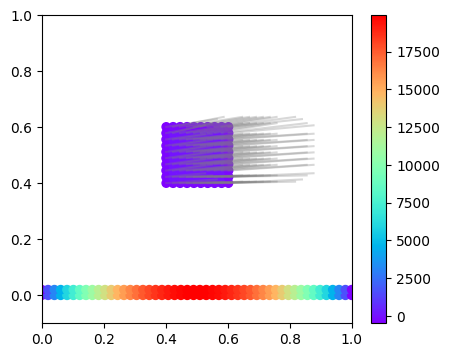

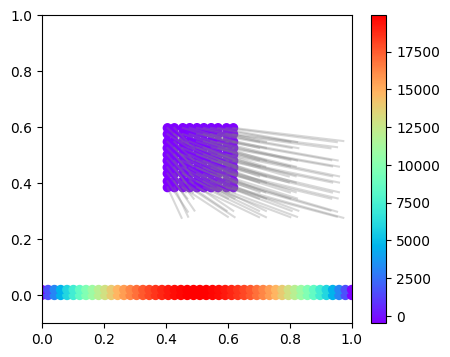

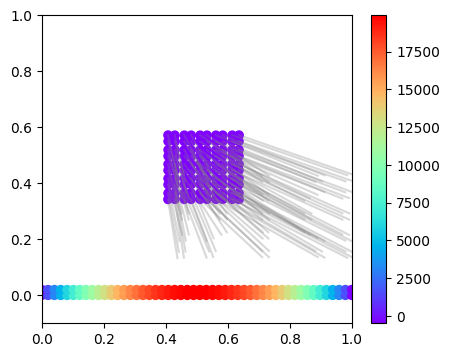

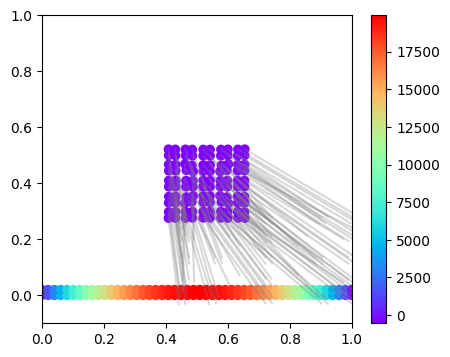

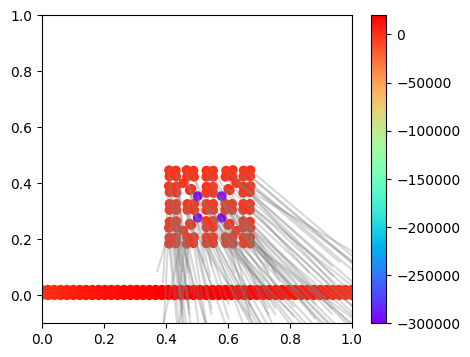

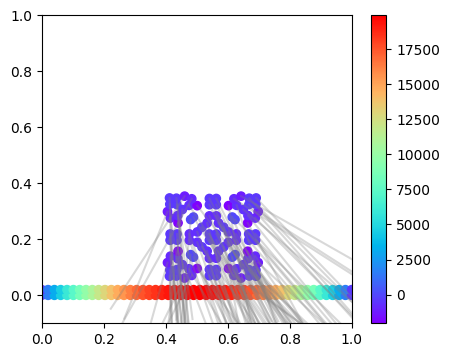

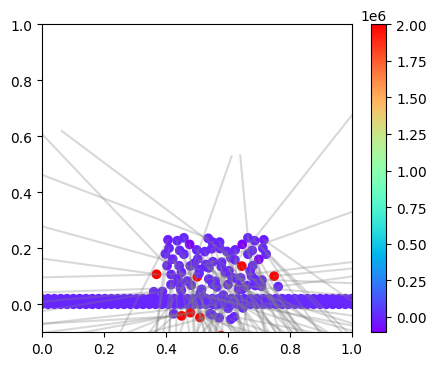

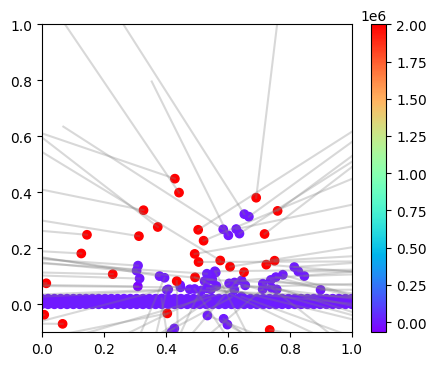

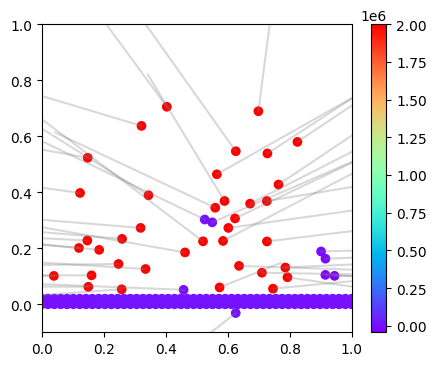

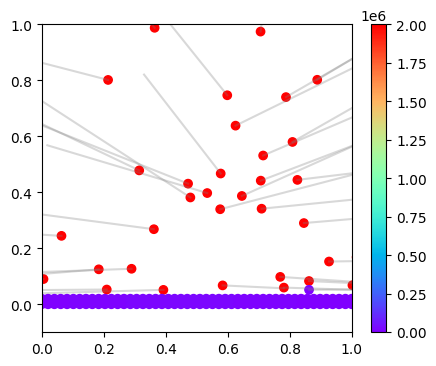

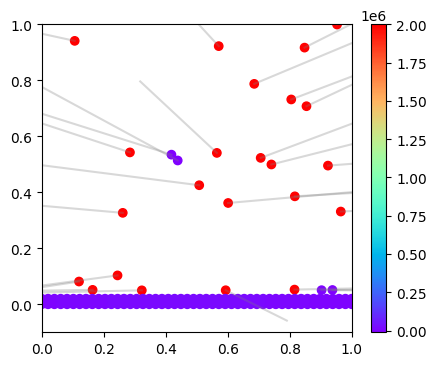

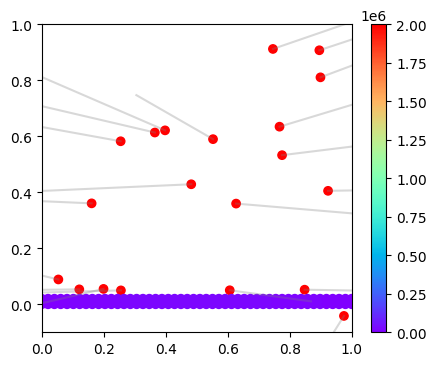

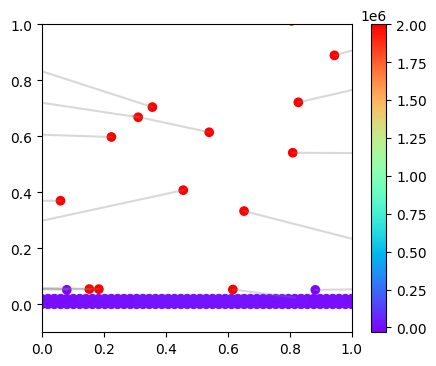

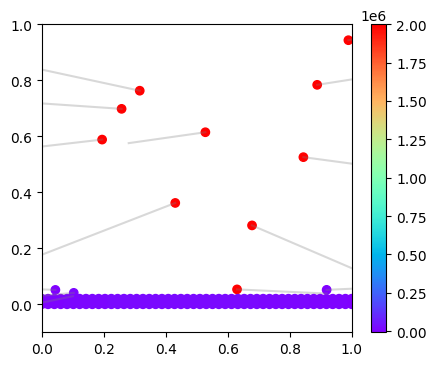

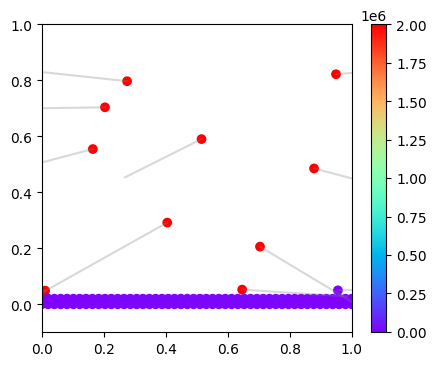

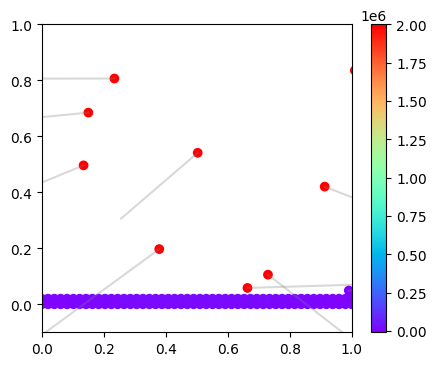

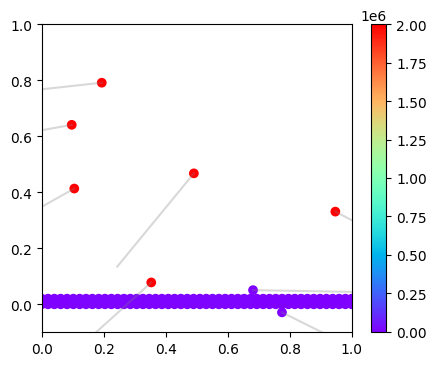

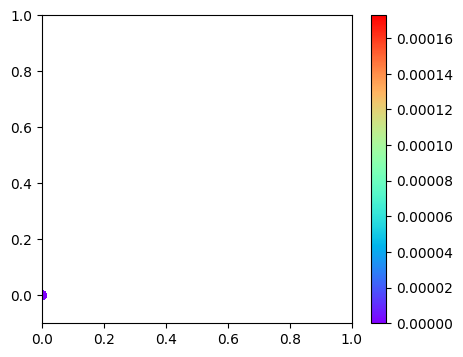

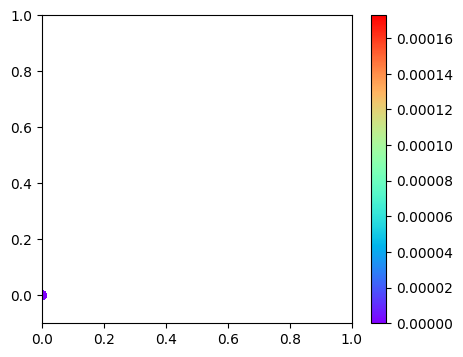

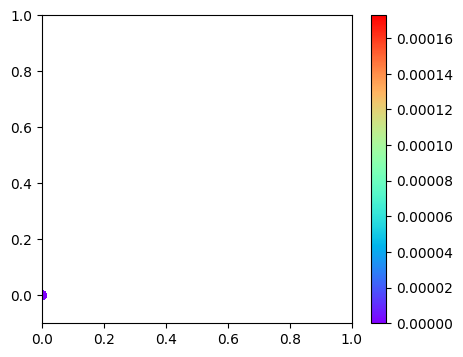

In [207]:
def plot_particle_(pos, vel=False, p=False):
    plt.scatter(*pos.T, c=p)
    plt.plot(np.block([pos, pos+vel])[:, ::2].T, np.block([pos, pos+vel])[:, 1::2].T, c='blue')
    plt.xlim(0,1)
    plt.ylim(0,1)


for i in range(0, 100, 5):
    pos=pos_timeseries[i]
    vel=vel_timeseries[i]
    p=p_timeseries[i]
    
    plt.figure(figsize=(5,4))
    plt.scatter(*pos.T, c=p, cmap="rainbow")
    plt.plot(np.block([pos, pos+vel])[:, ::2].T, np.block([pos, pos+vel/5])[:, 1::2].T, c='gray', alpha=0.3)
    plt.colorbar()
    plt.xlim(0,1)
    plt.ylim(-0.1,1)

In [187]:
p_timeseries[5]

array([ 3.77656311e+38,  3.77656306e+38,  3.77656211e+38,  3.77656251e+38,
        3.77656213e+38,  3.77656313e+38,  3.77656244e+38,  3.77656250e+38,
        3.77656264e+38,  3.77656242e+38,  3.77656228e+38,  3.77656282e+38,
        3.77656220e+38,  3.77656285e+38,  3.77656468e+38,  3.77656454e+38,
        3.77656455e+38,  3.77656455e+38,  3.77656455e+38,  3.77656455e+38,
        3.77656454e+38,  3.77656454e+38,  3.77656455e+38,  3.77656454e+38,
        3.77656452e+38,  3.77656454e+38,  3.77656454e+38,  3.77656452e+38,
        3.77656454e+38,  3.77656452e+38,  3.77656271e+38,  3.77656275e+38,
        3.77656246e+38,  3.77656206e+38,  3.77656244e+38,  3.77656268e+38,
        3.77656213e+38,  3.77656328e+38,  3.77656205e+38,  3.77656269e+38,
        3.77656284e+38,  3.77656266e+38,  3.77656255e+38,  3.77656270e+38,
        3.77656465e+38,  3.77656454e+38,  3.77656452e+38,  3.77656453e+38,
        3.77656453e+38,  3.77656455e+38,  3.77656455e+38,  3.77656454e+38,
        3.77656454e+38,  